## Import Libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import os
from itertools import chain

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# import transform_fns as trans
import pdm_functions as fns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import gaussian_kde

import pickle



## Weight계산 

In [2]:
# df_normal= pd.read_csv('dataset/5528_spec_normal.csv')
# df_error= pd.read_csv('dataset/5528_spec_error.csv')

In [3]:
# df_normal['spectrum_x_amp']= df_normal['spectrum_x_amp'].apply(lambda x: [float(num) for num in x.split(',')][1:])
# df_normal['spectrum_y_amp']= df_normal['spectrum_y_amp'].apply(lambda x: [float(num) for num in x.split(',')][1:])
# df_normal['spectrum_z_amp']= df_normal['spectrum_z_amp'].apply(lambda x: [float(num) for num in x.split(',')][1:])

In [4]:
# wf_x = fns.rpm_approx_weighted_fn(df_normal['spectrum_x_amp'], 1, 2048, 2048)
# wf_y = fns.rpm_approx_weighted_fn(df_normal['spectrum_y_amp'], 1, 2048, 2048)
# wf_z = fns.rpm_approx_weighted_fn(df_normal['spectrum_z_amp'], 1, 2048, 2048)

In [5]:
# file_path = file_path = 'dataset/train_datasets/5520_spectrum_x_weights.pkl'
# with open(file_path, 'wb') as f:
    # pickle.dump(wf_x, f)
    
# file_path = file_path = 'dataset/train_datasets/5520_spectrum_y_weights.pkl'
# with open(file_path, 'wb') as f:
#     pickle.dump(wf_y, f)
    
# file_path = file_path = 'dataset/train_datasets/5520_spectrum_z_weights.pkl'
# with open(file_path, 'wb') as f:
#     pickle.dump(wf_z, f)

In [6]:
file_path = file_path = 'dataset/train_datasets/5520_spectrum_x_weights.pkl'
with open(file_path, 'rb') as f: 
    data = pickle.load(f)
wf_x = data

file_path = file_path = 'dataset/train_datasets/5520_spectrum_y_weights.pkl'
with open(file_path, 'rb') as f: 
    data = pickle.load(f)
wf_y = data

file_path = file_path = 'dataset/train_datasets/5520_spectrum_z_weights.pkl'
with open(file_path, 'rb') as f: 
    data = pickle.load(f)
wf_z = data
          

<Axes: >

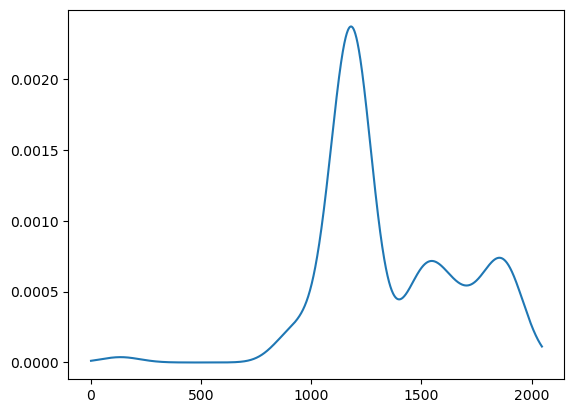

In [7]:
sns.lineplot(wf_x)

### <span style='color:red'> 가중치 standardization </span>

In [8]:
# wf = fns.min_max_standardization(wf)

In [9]:
wf = wf_x + wf_y + wf_z

In [10]:
wf = wf * 12
wf = torch.tensor(wf)

## 데이터셋 (tensors)

In [11]:
# df_normal = fns.csv_to_tensor_stack('dataset/5528_spec_normal.csv')
# df_error = fns.csv_to_tensor_stack('dataset/5528_spec_error.csv')

## Well-distributed test set

In [12]:
file_path = file_path = 'dataset/train_datasets/train_sets.pkl'
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Access the loaded data
X_train_pickle = data['X_train']
y_train_pickle = data['y_train']

print("Loaded X_train:", X_train_pickle)
print("Loaded y_train:", y_train_pickle)

Loaded X_train: tensor([[6.4164e-04, 6.9671e-04, 4.5043e-04,  ..., 3.1335e-05, 1.6753e-04,
         2.6539e-04],
        [5.7142e-05, 5.6895e-05, 3.8271e-05,  ..., 1.9522e-04, 3.5067e-04,
         3.5810e-04],
        [2.7202e-04, 4.8636e-04, 5.3246e-04,  ..., 5.2438e-03, 1.7740e-03,
         1.1917e-03],
        ...,
        [1.1860e-04, 7.7795e-05, 1.0226e-04,  ..., 2.1402e-03, 1.8804e-03,
         1.6231e-03],
        [9.9313e-05, 1.4456e-04, 2.2368e-04,  ..., 5.0263e-04, 5.0777e-04,
         5.9311e-04],
        [3.7712e-04, 4.5022e-04, 4.5768e-04,  ..., 3.3496e-04, 3.8365e-04,
         1.2905e-04]])
Loaded y_train: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.00

C:\Users\user\anaconda3\envs\kdtproj\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


## 데이터셋에 가중치 곱하기

In [13]:
# df_normal = X_train_pickle * wf
# df_error = df_error * wf
# df_normal.shape, wf.shape

NameError: name 'df_error' is not defined

## 데이터셋 숫자 늘리기
### <span style='color:red'> 몇 배로 데이터를 늘릴 것인가 multi_dim </span>

In [20]:
# df_normal_aug = fns.multi_datasets(df_normal, multi_dim=50, num_groups=12)
# df_error_aug = fns.multi_datasets(df_error, multi_dim= 550, num_groups=12)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 94.76it/s]


NameError: name 'df_error' is not defined

In [14]:
# len(y_train_pickle[y_train_pickle == float(1)]), len(y_train_pickle[y_train_pickle != float(1)])

In [15]:
# y_train_pickle

In [16]:
# X_train_normal = X_train_pickle[:111]
# y_train_normal =y_train_pickle[:111]
# X_train_normal.shape, y_train_normal

In [17]:
# X_train_error = X_train_pickle[-10:]
# y_train_error = y_train_pickle[-10:]
# X_train_error.shape, y_train_error

In [18]:
# X_train_error_aug = fns.multi_datasets(X_train_error, multi_dim=10, num_groups=12)
# y_train_error_aug = y_train_error.repeat(10)

In [19]:
# X_train_error_aug.shape, y_train_error_aug.shape

In [20]:
# y_train_error_aug

In [21]:
# X_train_wd = torch.concat((X_train_normal, X_train_error_aug), dim=0)
# y_train_wd = torch.concat((y_train_normal, y_train_error_aug), dim=0)

In [22]:
# X_train_wd.shape, y_train_wd.shape

In [23]:
# sns.lineplot(y_train_wd)

In [24]:
# X_train_wd_aug = fns.multi_datasets(X_train_wd, multi_dim=100, num_groups=12)
# y_train_wd_aug = y_train_wd.repeat(100)
# X_train_wd_aug.shape, y_train_wd_aug.shape

In [25]:
# len(y_train_wd_aug[y_train_wd_aug == 1]), len(y_train_wd_aug[y_train_wd_aug != 1])

In [26]:
# file_path= 'dataset/train_datasets/train_set_wd_aug.pkl'
# with open(file_path, 'wb') as f:
#     pickle.dump({'X_train_wd_aug' : X_train_wd_aug, 'y_train_wd_aug': y_train_wd_aug}, f)

In [27]:
# file_path= 'dataset/train_datasets/train_set_wd_aug.pkl'
# with open(file_path, 'rb') as f:
#     data = pickle.load(f)

# X_train_wd_aug = data['X_train_wd_aug']
# y_train_wd_aug = data['y_train_wd_aug']

C:\Users\user\anaconda3\envs\kdtproj\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [28]:
X_train_wd_aug = X_train_wd_aug * wf

In [29]:
# X_train, X_test, y_train, y_test= fns.binary_labeling(df_normal_aug, df_error_aug, test_size=.002, random_state=42 )

In [30]:
# X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [31]:
# print(len(y_train[y_train == 0 ]), len(y_train[y_train == 1]))
# print(len(y_test[y_test == 0 ]), len(y_test[y_test == 1]))

In [32]:
# X_test.shape

In [33]:
# X_train_aug = fns.multi_datasets(X_train, multi_dim=3, num_groups=12)
# y_train = y_train.repeat(10)

In [34]:
# print(X_train_aug.shape, y_train.shape)

In [35]:
# df_error_aug = fns.multi_datasets(df_error, multi_dim= 1100, num_groups=12)
#

In [36]:
file_path='dataset/train_datasets/dev_sets.pkl'
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Access the loaded data
X_dev_pickle = data['X_dev']
y_dev_pickle = data['y_dev']

print("Loaded X_dev:", X_dev_pickle)
print("Loaded y_dev:", y_dev_pickle)

Loaded X_dev: tensor([[2.1043e-04, 2.9448e-04, 2.4472e-04,  ..., 6.1457e-04, 6.1808e-04,
         5.6178e-04],
        [1.9647e-04, 2.4157e-04, 1.7535e-04,  ..., 1.1232e-04, 1.7699e-04,
         3.0490e-04],
        [2.6128e-04, 2.2513e-04, 1.0218e-04,  ..., 9.2347e-04, 7.9336e-04,
         4.3334e-04],
        ...,
        [4.0388e-04, 4.1982e-04, 2.7370e-04,  ..., 5.8726e-04, 7.4385e-04,
         7.6368e-04],
        [2.0376e-04, 3.0760e-04, 3.0270e-04,  ..., 9.7332e-04, 5.4711e-04,
         3.4396e-05],
        [7.4707e-05, 9.6044e-05, 2.9320e-04,  ..., 5.0607e-04, 6.4545e-04,
         5.9695e-04]])
Loaded y_dev: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8991, 0.9672,
        0.9818])


In [37]:
dev_x = X_dev_pickle
dev_y = y_dev_pickle

In [38]:
# dev_x.shape

In [39]:
dev_x = fns.multi_datasets(X_dev_pickle, multi_dim = 2, num_groups= 12)
dev_y = y_dev_pickle.repeat(2)
# dev_x.shape, dev_y.shape

In [40]:
dev_x = dev_x * wf

## 데이터 상위 x개 추출
### <span style='color:red'> get_sorted_top_k_values(data, k = 5000)</span>

In [41]:
X_train = fns.get_sorted_top_k_values(X_train_wd_aug, 5000)
y_train = y_train_wd_aug
# X_test = fns.get_sorted_top_k_values(X_test, 5000)
X_dev_pickle = fns.get_sorted_top_k_values(dev_x, 5000)

In [42]:
X_train.shape, y_train.shape, X_dev_pickle.shape, dev_y.shape

(torch.Size([21100, 5000]),
 torch.Size([21100]),
 torch.Size([74, 5000]),
 torch.Size([74]))

<Axes: >

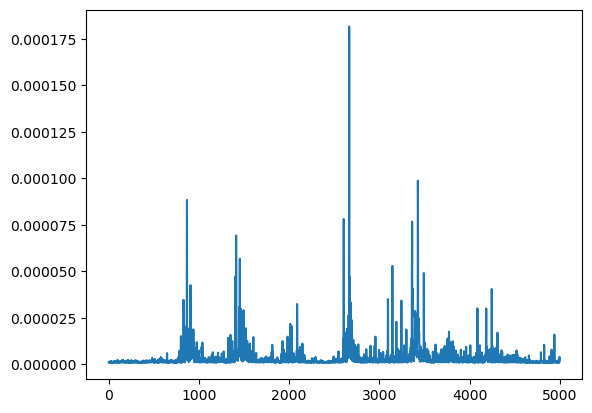

In [43]:
sns.lineplot(X_train[1])

### <span style="color:red"> Input값이 너무 작을 경우 곱셈으로 늘려준다 (예: * 1000)  </span>

In [44]:
train_x = fns.get_sorted_top_k_values(X_train) * 100000
# test_x = fns.get_sorted_top_k_values(X_test) * 100000

In [45]:
dev_x = fns.get_sorted_top_k_values(X_dev_pickle) * 100000

<Axes: >

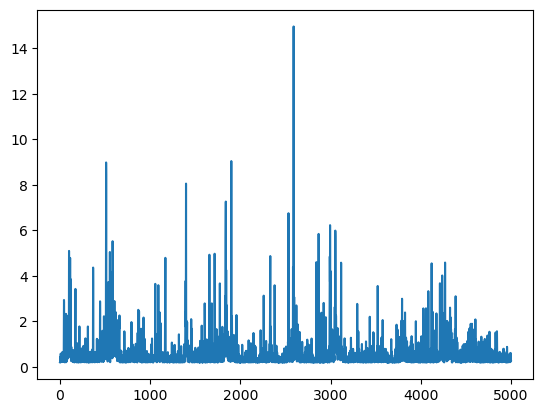

In [46]:
sns.lineplot(train_x[0])

<Axes: >

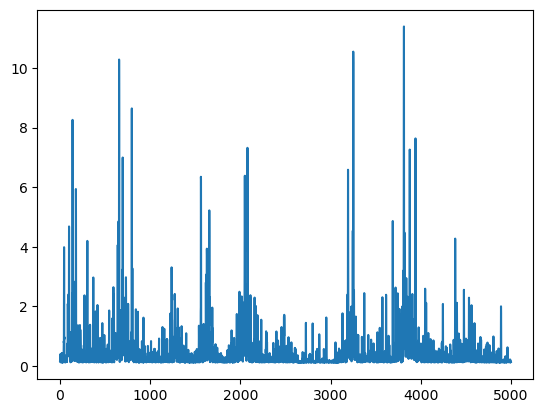

In [47]:
sns.lineplot(dev_x[1])

In [48]:
# sns.lineplot(test_x[1])

In [49]:
train_label = y_train
# test_label = y_test
dev_label = dev_y

In [50]:
train_x.shape, train_label.shape

(torch.Size([21100, 5000]), torch.Size([21100]))

In [51]:
dev_x.shape, dev_y.shape

(torch.Size([74, 5000]), torch.Size([74]))

In [52]:
# test_x.shape, test_label.shape

In [53]:
train_dataset = TensorDataset(train_x, train_label)

In [54]:
# test_dataset = TensorDataset(test_x, test_label)

In [55]:
dev_dataset = TensorDataset(dev_x, dev_label)

In [56]:
dataloader = DataLoader(train_dataset, batch_size=251, shuffle=True)

In [57]:
# dataloader_test = DataLoader(test_dataset, shuffle=True)

In [58]:
dataloader_dev = DataLoader(dev_dataset,  shuffle=True)

## Model Structure

In [59]:
learning_rate = 0.001
num_epochs = 10

model = nn.Sequential(    
    nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0),  
    nn.ReLU(), 
    nn.MaxPool1d(kernel_size=2),  
    nn.BatchNorm1d(16),
    nn.Conv1d(in_channels=16, out_channels=32, kernel_size=4, stride=1, padding=0),  
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=4),
    nn.BatchNorm1d(32),
    nn.Conv1d(in_channels=32, out_channels=16, kernel_size=4, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=4),
    nn.BatchNorm1d(16),
    nn.Flatten(),
    nn.Linear(2480, 1240),  # Adjust according to the actual output size after the last Conv1d
    nn.ReLU(), 
    nn.Dropout(0.3), 
    nn.Linear(1240, 620),
    nn.ReLU(), 
    nn.Dropout(.3),
    nn.Linear(620, 310), 
    nn.ReLU(), 
    nn.Linear(310, 128), 
    nn.ReLU(), 
    nn.Linear(128, 64), 
    nn.ReLU(),
    nn.Linear(64, 2),
)

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [60]:
print(model)

Sequential(
  (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (1): ReLU()
  (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv1d(16, 32, kernel_size=(4,), stride=(1,))
  (5): ReLU()
  (6): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Conv1d(32, 16, kernel_size=(4,), stride=(1,))
  (9): ReLU()
  (10): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (11): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=2480, out_features=1240, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.3, inplace=False)
  (16): Linear(in_features=1240, out_features=620, bias=True)
  (17): ReLU()
  (18): Dropout(p=0.3, inplace=False)
  (19):

### Model Training

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for x_batch, labels in dataloader:
        optimizer.zero_grad()

        # Reshape x_batch to have one input channel
        x_batch = x_batch.unsqueeze(1)  # Reshape: (batch_size, 1, 5000)
        x_batch = x_batch.to(device)  # Move x_batch to device
        labels = labels.to(device)  # Move labels to device
        labels = labels.to(device).long()  
        
        outputs = model(x_batch)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

cuda
Epoch [1/10], Loss: 0.2493
Epoch [2/10], Loss: 0.0309
Epoch [3/10], Loss: 0.0140
Epoch [4/10], Loss: 0.0281
Epoch [5/10], Loss: 0.0053
Epoch [6/10], Loss: 0.0102
Epoch [7/10], Loss: 0.0051
Epoch [8/10], Loss: 0.0034
Epoch [9/10], Loss: 0.0057
Epoch [10/10], Loss: 0.0206


## Model Evaluation

In [62]:
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

# Initialize variables to keep track of the loss and predictions
total_loss = 0.0
all_labels = []
all_predictions = []
correct_cnt = 0
neg_pred_cnt = 0 

with torch.no_grad():
    for x_batch, labels in dataloader_dev:  # Assuming you have a separate validation or test DataLoader
        # Reshape x_batch to have one input channel
        x_batch = x_batch.unsqueeze(1)  # Reshape: (batch_size, 1, 5000)
        x_batch = x_batch.to(device)  # Move x_batch to device
        
        # labels = labels.to(device)
        labels = labels.to(device).long() #DEV로 평가할 경우
        
        outputs = model(x_batch)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        
        total_loss += loss.item()  # Accumulate the loss
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
        
        all_labels.extend(labels.cpu().numpy())  # Store true labels
        all_predictions.extend(predicted.cpu().numpy())  # Store predicted labels

# Calculate average loss
avg_loss = total_loss / len(dataloader)

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions, average='weighted')  # Use 'micro' or 'macro' if needed
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

cm = confusion_matrix(all_labels, all_predictions)

TN = cm[0, 0]  
FP = cm[0, 1] 
FN = cm[1, 0]  
TP = cm[1, 1]  

FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  
FNR = FN / (FN + TP) if (FN + TP) > 0 else 0  

# Print results
print(f"Evaluation Loss: {avg_loss:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
print(f'Predicted positives out of all negatives: {FPR} = {FP}/{FP + TN}')
print(f'Predicted negatives out of all positives: {FNR} = {FN}/{FN + TP}')
print(all_labels)
print(all_predictions)
for i in range(len(all_labels)) :
    if all_labels[i] == 0 and all_predictions[i] == 0:
        correct_cnt += 1
for pred in all_predictions:
    if pred == 0:
        neg_pred_cnt += 1

print(f'correct_cnt {correct_cnt}')
print(f'neg_pred_cnt {neg_pred_cnt}')
# len(all_labels)

cuda
Evaluation Loss: 3.9140
Precision: 0.8378, Recall: 0.8378, F1 Score: 0.8378
Predicted positives out of all negatives: 1.0 = 6/6
Predicted negatives out of all positives: 0.08823529411764706 = 6/68
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
correct_cnt 0
neg_pred_cnt 6


## 모델 저장

In [63]:
# torch.save(model, 'model_v0.0.4.pth')